找到的字符数量: 10


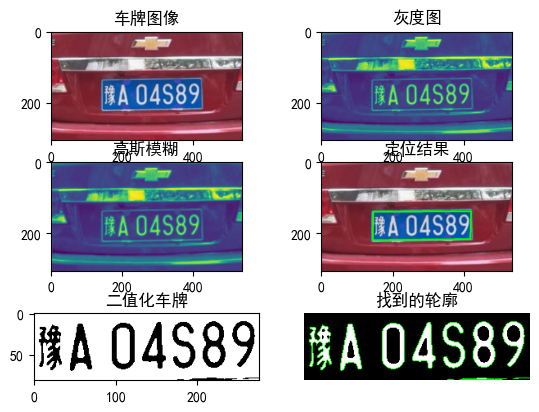

In [1]:
import cv2
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.sans-serif'] = ['SimHei']  # 这里选择合适的中文字体
rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示为方块的问题

# 读取图像默认BGR
image = cv2.imread('F:/20241022222909.png')
plt.figure()
# 检查图像是否成功加载
if image is None:
    print("Error: Could not load image. Check the file path.")
else:
    # 图像加载成功，继续处理
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 显示原图像
    plt.subplot(3,2,1)
    plt.imshow(image_rgb)
    plt.title("车牌图像")

# 转换为灰度图像
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.subplot(3,2,2)
plt.imshow(gray)
plt.title("灰度图")
# 使用高斯模糊来减少噪声
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.subplot(3,2,3)
plt.imshow(blurred)
plt.title("高斯模糊")

# 使用Canny边缘检测
edged = cv2.Canny(blurred, 30, 150)

# 找到轮廓
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 假设车牌是面积最大的矩形
contour_img = image.copy()
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
plate_contour = None

# 遍历轮廓，寻找可能的车牌
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    if len(approx) == 4:  # 车牌大多是矩形
        plate_contour = approx
        break

if plate_contour is not None:
    cv2.drawContours(contour_img, [plate_contour], -1, (0, 255, 0), 3)
    plt.subplot(3,2,4)
    plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    plt.title('定位结果')

    
# 提取车牌区域
if plate_contour is not None:
    x, y, w, h = cv2.boundingRect(plate_contour)
    plate_image = gray[y:y+h, x:x+w]

    # 二值化处理
    _, thresh = cv2.threshold(plate_image, 150, 255, cv2.THRESH_BINARY_INV)

    # 显示二值化图像
    plt.subplot(3,2,5)
    plt.imshow(thresh, cmap='gray')
    plt.title("二值化车牌")

    # 使用轮廓分割字符
    character_contours, _ = cv2.findContours(~thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 打印字符轮廓的数量
    print(f'找到的字符数量: {len(character_contours)}')
    # 显示找到的轮廓
    contour_image = cv2.cvtColor(~thresh, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, character_contours, -1, (0, 255, 0), 1)
    plt.subplot(3,2,6)
    plt.imshow(contour_image)
    plt.title("找到的轮廓")
    plt.axis('off')
    plt.show()

In [4]:
# 设置最小和最大轮廓面积阈值
min_area = 100  # 最小轮廓面积
max_area = 4000  # 最大轮廓面积（可以根据需要调整）

# 过滤轮廓
filtered_contours = [
contour for contour in character_contours 
if min_area < cv2.contourArea(contour) < max_area
]
# 再次打印过滤后的字符数量
print(f'过滤后的字符数量: {len(filtered_contours)}')


过滤后的字符数量: 7


In [5]:
import os
import numpy as np
# 准备模板
template = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                            'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
                            'U', 'V', 'W', 'X', 'Y', 'Z',
                            '藏', '川', '鄂', '甘', '赣', '贵', '桂', '黑', '沪', '吉', '冀', '津', '晋', '京', '辽', '鲁', '蒙', '闽',
                            '宁',
                            '青', '琼', '陕', '苏', '皖', '湘', '新', '渝', '豫', '粤', '云', '浙']
# 读取一个文件夹下的所有图片，输入参数是文件名，返回文件地址列表
def read_directory(directory_name):
    referImg_list = []
    for filename in os.listdir(directory_name):
        referImg_list.append(directory_name + "/" + filename)
    return referImg_list

# 中文模板列表（只匹配车牌的第一个字符）
def get_chinese_words_list():
    chinese_words_list = []
    for i in range(34,64):
        c_word = read_directory('./refer1/'+ template[i])
        chinese_words_list.append(c_word)
    return chinese_words_list
chinese_words_list = get_chinese_words_list()

# 英文模板列表（只匹配车牌的第二个字符）
def get_eng_words_list():
    eng_words_list = []
    for i in range(10,34):
        e_word = read_directory('./refer1/'+ template[i])
        eng_words_list.append(e_word)
    return eng_words_list
eng_words_list = get_eng_words_list()

# 英文数字模板列表（匹配车牌后面的字符）
def get_eng_num_words_list():
    eng_num_words_list = []
    for i in range(0,34):
        word = read_directory('./refer1/'+ template[i])
        eng_num_words_list.append(word)
    return eng_num_words_list
eng_num_words_list = get_eng_num_words_list()


# 读取一个模板地址与图片进行匹配，返回得分
def template_score(template,image):
    template_img=cv2.imdecode(np.fromfile(template,dtype=np.uint8),1)
    template_img = cv2.cvtColor(template_img, cv2.COLOR_RGB2GRAY)
    ret, template_img = cv2.threshold(template_img, 0, 255, cv2.THRESH_OTSU)
    result = cv2.matchTemplate(image, template_img, cv2.TM_CCOEFF)#相关系数匹配，返回值愈大，匹配值越高
    return result[0][0]

def template_matching(word_image,index):
    results = []
    
    if index == 0:
        best_score = []
        for chinese_words in chinese_words_list:
            score = []
            for chinese_word in chinese_words:
                result = template_score(chinese_word,word_image)
                score.append(result)
            best_score.append(max(score))
        i = best_score.index(max(best_score))
        r = template[34+i]
        results.append(r)
        
    if index==1:
        best_score = []
        for eng_word_list in eng_words_list:
            score = []
            for eng_word in eng_word_list:
                result = template_score(eng_word,word_image)
                score.append(result)
            best_score.append(max(score))
        i = best_score.index(max(best_score))
        r = template[10+i]
        results.append(r)
    
    else:
        best_score = []
        for eng_num_word_list in eng_num_words_list:
            score = []
            for eng_num_word in eng_num_word_list:
                result = template_score(eng_num_word,word_image)
                score.append(result)
            best_score.append(max(score))
        i = best_score.index(max(best_score))
        r = template[i]
        results.append(r)
    return results

TypeError: can only concatenate str (not "list") to str

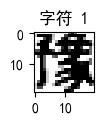

In [8]:

# 模板匹配识别字符
recognized_text = ""

for index, contour in enumerate(filtered_contours):
    (x, y, w, h) = cv2.boundingRect(contour)
    word_image = thresh[y:y+h, x:x+w]
    # 可选: 进一步调整字符图像的大小以便更好地进行识别
    character = cv2.resize(word_image, (20, 20))  # 例如调整为 20x20 的大小
    plt.subplot(1, len(filtered_contours), index+1)
    plt.imshow(character, cmap='gray')
    plt.title(f'字符 {index+1}')
    # 在模板中进行匹配（未实现）
    recognized_text+=template_matching(word_image,index)
plt.show()
print(f"识别的车牌字符: {recognized_text}")


